## Main components

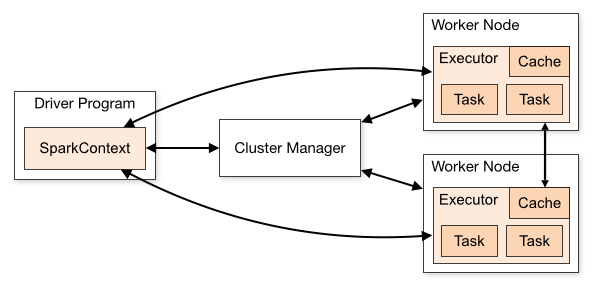

__Driver Program / Master node, SparkContext__ - Responsible for creating task and partition data info + configuration + distributed variables. We can use it with Python, Scala, Java, R, C++. It can be placed on client's machine or as a virtual machine in a cloud. Runs on JVM (Java Virtual Machine).

__Worker Node__ - Most often a virtual machine in the cloud, but can be placed on the client's machine.

__Executor__ - processes tasks given by the Driver. Executors can run in parallel with other tasks. They consist of __slots__. There are as many slots for an executor as many CPU cores are available for that executor. After the task is done it send results, logs and matrics back to the Driver.

__Task__ - runs on slots. One task can run on one slot. Tasks can be processed in parallel to other tasks. They can communicate with each other.

__Cluster Manager__ - The prime work of the cluster manager is to divide resources across applications. It works as an external service for acquiring resources on the cluster. It has different types: Spark Standalone cluster, YARN mode, Spark Mesos and Kubernetes.

## Spark UI Jobs View

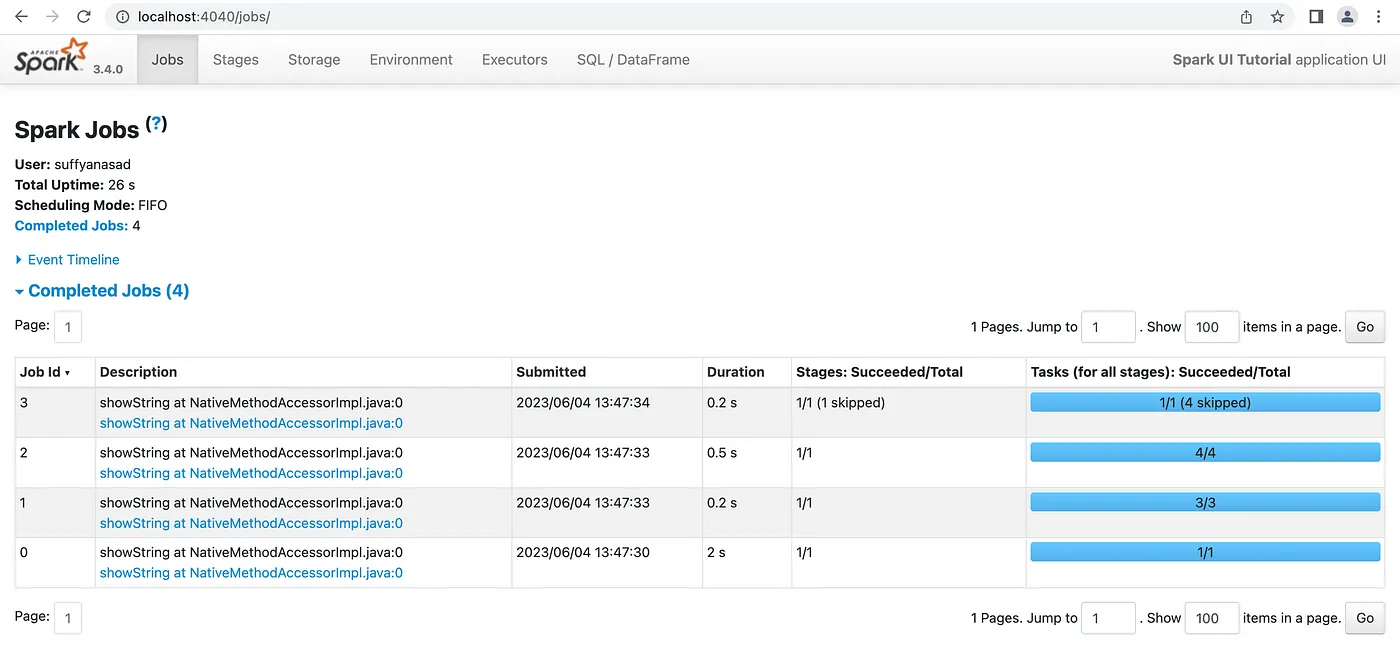

- Executors execute tasks and report the status. There can be one or more executors on a worker node. In case of databricks, it's always 1:1
- Driver plans jobs, stages and tasks and makes sure that those are executed. If an executor fails, it assigns a task to the another one. Driver, **_almost_** never, touches data
- There is as many slots on an executor as CPU cores
- There can be as many tasks executed by an executor in parallel as many slots
- Task is the smalles unit of work
- Data is splitted into partitions - 1 partition for 1 task
- Driver and the executors processes run on the Java Virtual Machine (JVM)

## Deployment modes

| Deployment mode |    Local computer    |         Cloud        |
|:---------------:|:--------------------:|:--------------------:|
| Local           | Driver and executors |           X          |
| Client          |        Driver        |       Executors      |
| Cluster         |           X          | Driver and executors |

## RDDs, DataFrames and DataSets

- __RDD (Resilient Distributed Dataset)__<br />
An RDD is the foundational data structure in Apache Spark, representing an _immutable_ distributed collection of objects that can be processed in parallel. It provides _fault tolerance, data lineage, and supports a wide range of transformations and actions_ for large-scale data processing.

- __DataFrames__<br />
DataFrames provide a _higher-level abstraction_ over RDDs, organizing data into _named columns_, similar to tables in relational databases. They offer optimizations through _Spark's Catalyst optimizer_ for efficient distributed processing, including advanced query optimization and code generation.

- __Datasets__<br />
Datasets combine the benefits of RDDs and DataFrames, offering a _strongly-typed_ object-oriented API with the optimization capabilities of DataFrames. They are type-safe, high-performance distributed data processing, leveraging both _compile-time type safety_ and runtime optimization.

## Transformations and Actions

__Transformations__
- Business logic you want to apply to your data
- They take one or more RDD/DataFrame/DataSet and transform it into a new one
- Lazy - they won't be executed unless they have to be
- Transformations can be either narrow or wide. Wide transformations require shuffling data between partitions:
- _Narrow_ examples: Filter, Select, Cast, Create new column
- _Wide_ examples: Group By, Sort, Join

__Actions__
- Demand for results
- Examples: Collect, Count, Save, Take, Show
- Actions kick off the computation (a.k.a. previous transformations)

## Jobs, Stages and Tasks

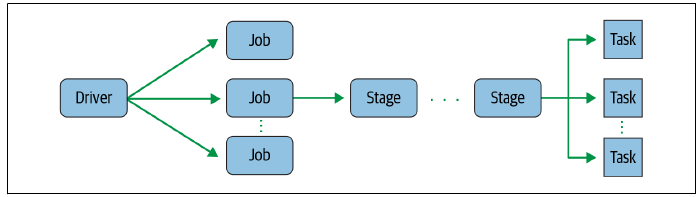

__Job__ - sequence of transformations on data. Whenever an action like `count()`, `first()`, `collect()`, and `save()` is called on RDD (Resilient Distributed Datasets), a job is created. A job could be thought of as the total work that Spark application needs to perform, broken down into a series of steps. Consider a scenario where you’re executing a Spark program, and you call the action `count()` to get the number of elements. This will create a Spark job. If further in your program, you call `collect()`, another job will be created. So, a Spark application could have multiple jobs, depending upon the number of actions.

__Stage__ - represents a sequence of transformations that can be executed in a single pass, i.e., without any shuffling of data. When a job is divided, it is split into stages. Each stage comprises tasks, and all the tasks within a stage perform the same computation. **_The boundary between two stages is drawn when transformations cause data shuffling across partitions_**. For wide transformations, data from all partitions may need to be combined, thus necessitating shuffling and marking the start of a new stage.

__Task__ - the smallest unit of work that can be scheduled. Each stage is divided into tasks. A task is a unit of execution that runs on a single machine. When a stage comprises transformations on an RDD, those transformations are packaged into a task to be executed on a single executor. For example, if you have a Spark job that is divided into two stages and you’re running it on a cluster with two executors, each stage could be divided into two tasks. Each executor would then run a task **_in parallel_**, performing the transformations defined in that task on its subset of the data.

## Data Shuffling

Shuffling is the process of distributing data across the cluster workers in order to process it in parallel. It happens generally when data is not evenly distributed, when data should be arranged in a specific way to be processed or when there is not enough memory on a single node to store all the required data for processing.

In order that spark ensures that all the records with the same key are on the same node, Spark needs to shuffle the data if performing operations like groupBy and joins on a large dataset. This makes it possible to process all the records at once and combine the results.

The shuffle operation must be finished before the next stage of processing can start, which can also delay the processing of the data.

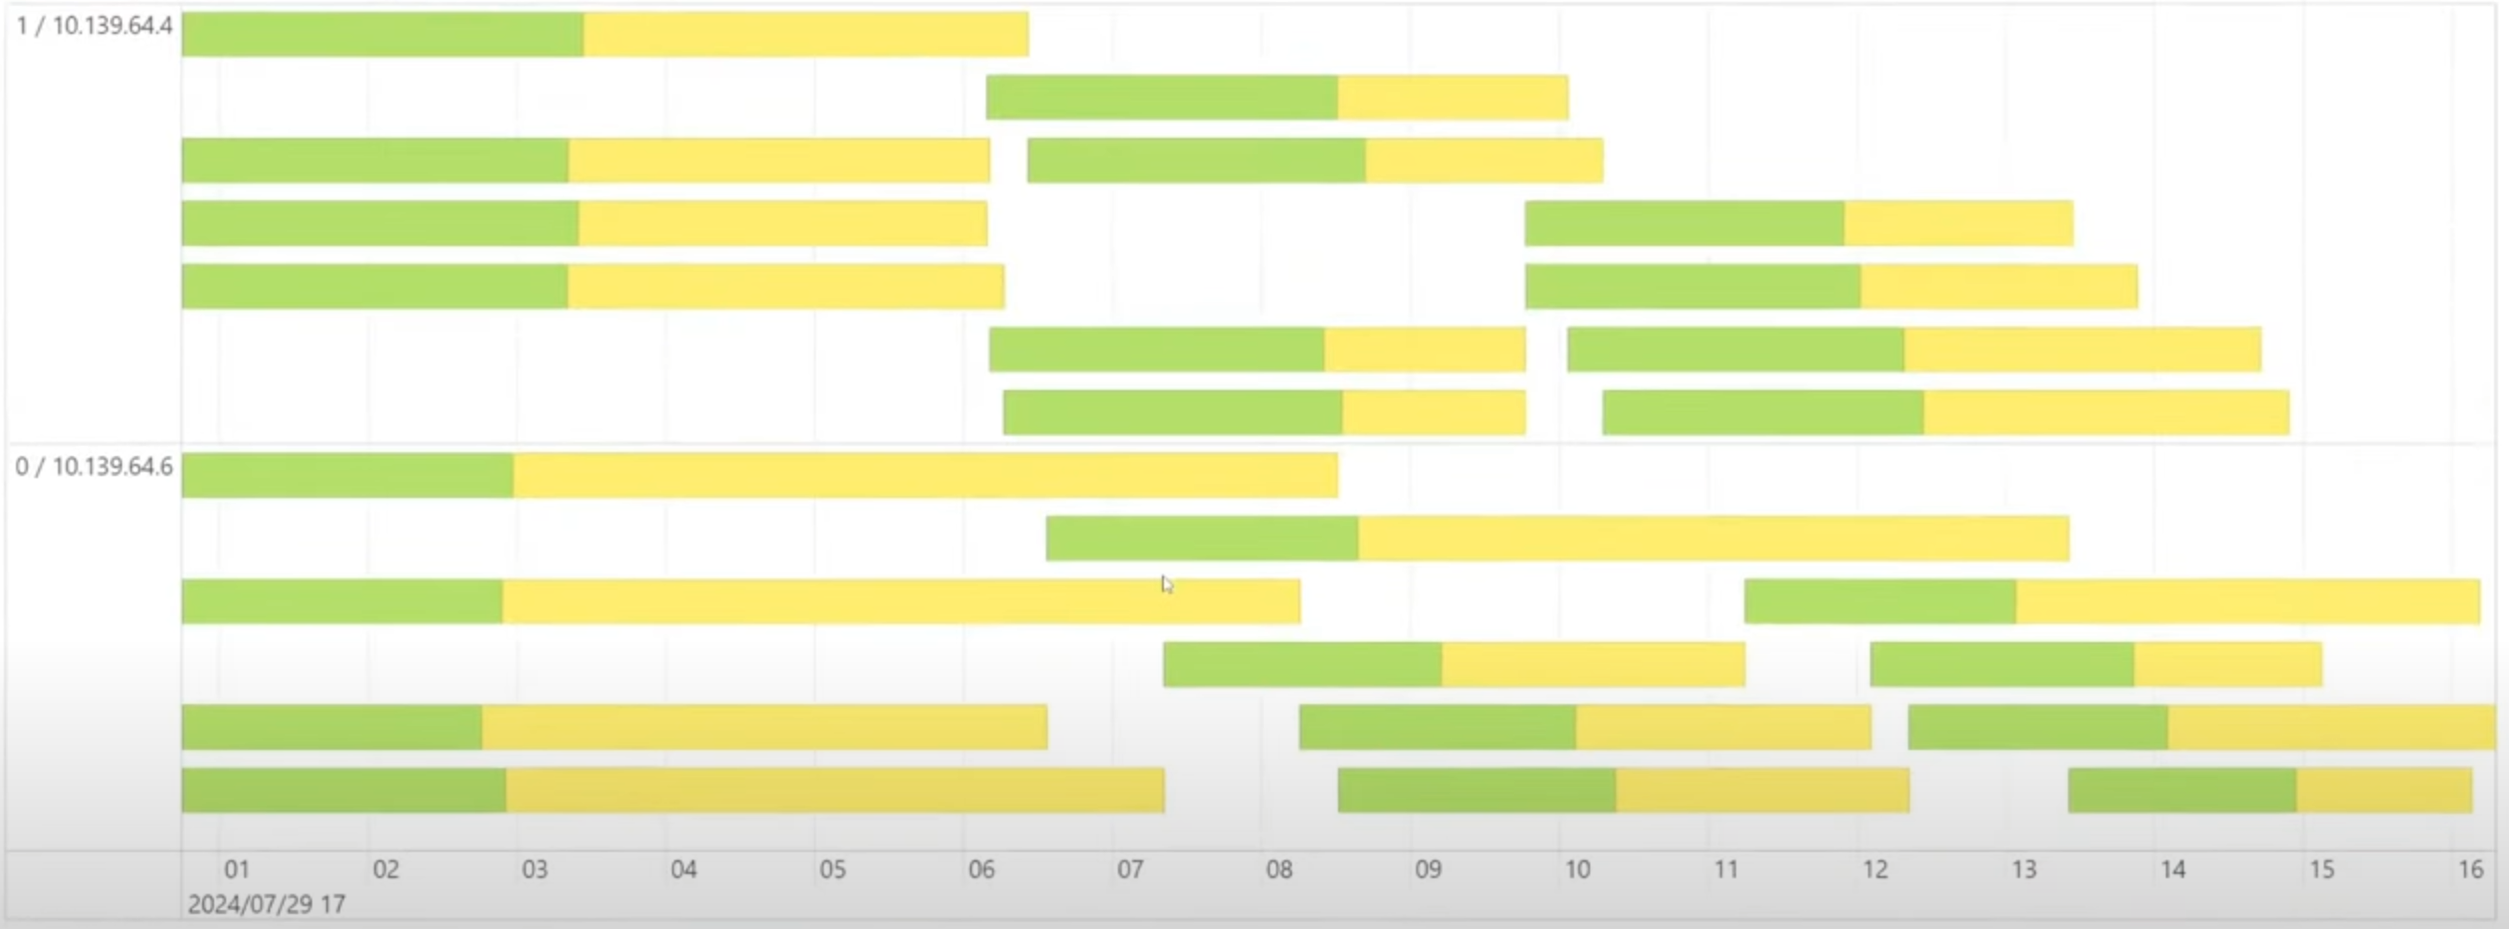

An example of grouping by column with almost every record unique. Green mean computation time and yellow shows Shuffle Write Time. This means that time required for shuffling was approximately the same as computing time.

## __Optimization__

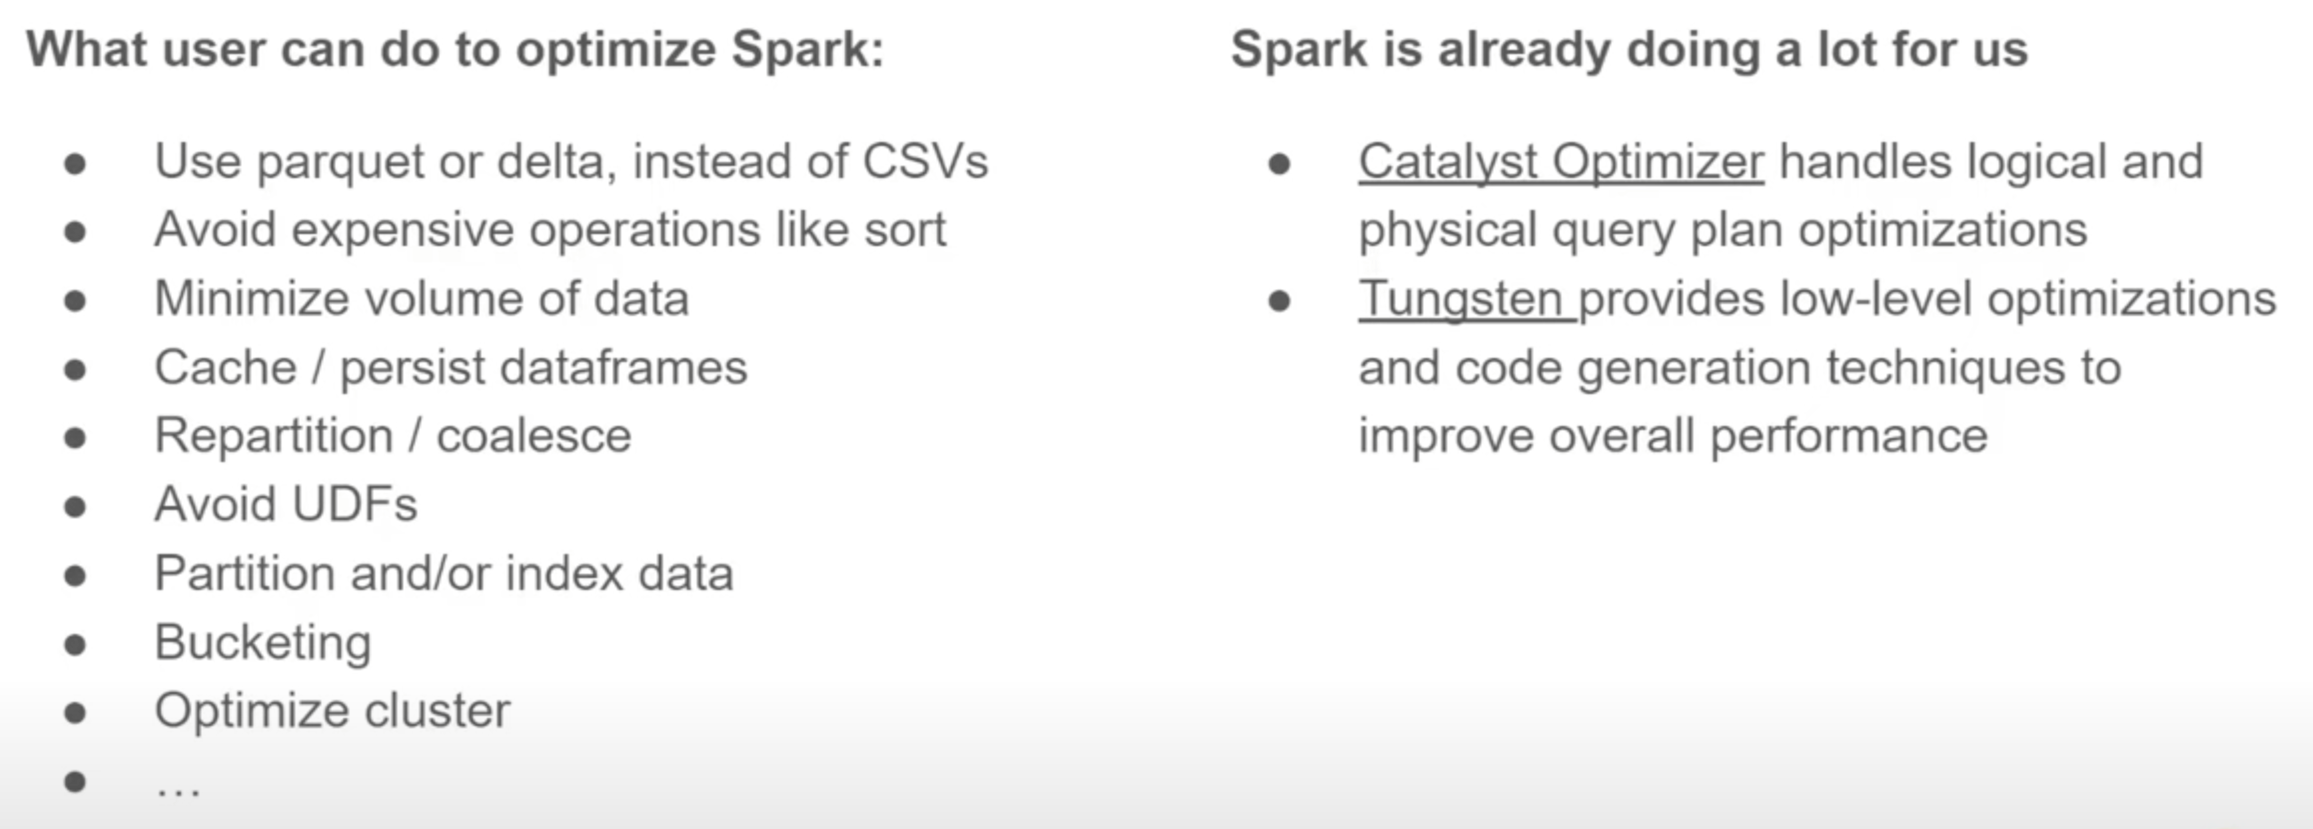

## Lazy Evaluation

Lazy evaluation is a feature in Spark, which holds off on executing transformations until an action is executed. For example, you can run a transformation to filter your dataframe - `df.filter()` - But Spark won’t actually filter your dataframe until you run an action e.g. showing your dataframe: `df.show()`.

By not executing transformations on a dataframe immediately, we avoid bringing the entire dataframe into memory immediately. This can save cluster capacity, as storing a dataframe in memory can be a resource-intensive operation. Another crucial optimization is how lazy evaluation is used in unison with a catalyst optimizer:
- Due to lazy loading, we end up having a bunch of transformations to run together.
- Then thanks to the catalyst optimizer, Spark doesn’t just run the pending transformations one by one. It looks at all the transformations it has to run, and figures out the most efficient way to **_combine_** them.

## Catalyst Optimizer

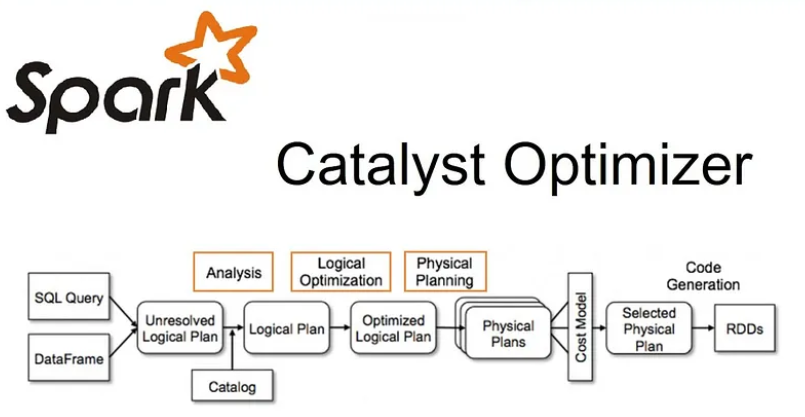

The catalyst optimizer has 3 key steps:

1. __Resolving logical plan__ - The first step for the catalyst optimizer is to make sure all references make sense. Do the column names your query contains exist? What columns are you trying to filter on? It’s a series of verifications.

2. __Optimizing logical plan__ - Now that the catalyst optimizer has confirmed and validated the operations you intend to perform on spark, it figures out several efficient logical plans. By efficient, we mean figuring out what type of join, when to filter your data, and applying other optimizations such as constant folding and predicate pushdown.

3. __Translating to a physical plan__ - We then end up with several optimized logical plans - some are more optimal than others depending on your resources. So next up is figuring out what resources you have. Spark looks at your cluster, figures out how much resource and execution time different plans require, then selects the most cost-efficient one given your capacity.

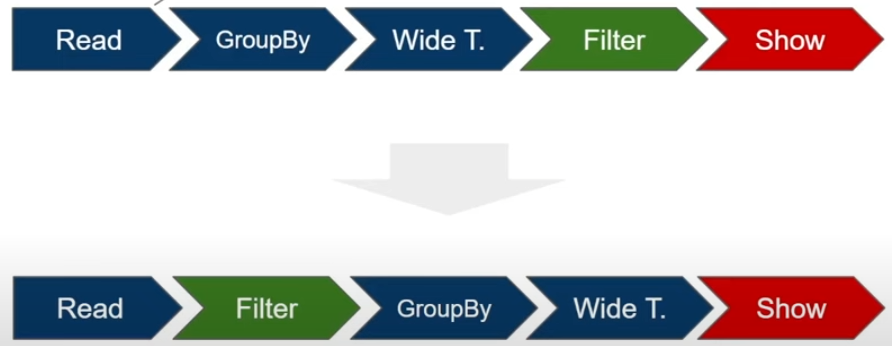

An example of logical plan optimalization - filtering data is moved to the begginig so the rest of the transformations (including wide) operate on lesser dataset which accelerates the process.

## Tungsten Project

Tungsten is the codename for the umbrella project to make changes to Apache Spark’s execution engine that focuses on substantially improving the efficiency of memory and CPU for Spark applications, to push performance closer to the limits of modern hardware.

#### Tungsten Project Includes These Initiatives:
- __Memory Management and Binary Processing__: leveraging application semantics to manage memory explicitly and eliminate the overhead of JVM object model and garbage collection
- __Cache-aware computation__: algorithms and data structures to exploit memory hierarchy
- __Code generation__: using code generation to exploit modern compilers and CPUs
- __No virtual function dispatches__: this reduces multiple CPU calls which can have a profound impact on performance when dispatching billions of times.
- __Intermediate data in memory vs CPU registers__: Tungsten Phase 2 places intermediate data into CPU registers. This is an order of magnitudes reduction in the number of cycles to obtain data from the CPU registers instead of from memory
- __Loop unrolling and SIMD__: Optimize Apache Spark’s execution engine to take advantage of modern compilers and CPUs’ ability to efficiently compile and execute simple for loops (as opposed to complex function call graphs).

The focus on CPU efficiency is motivated by the fact that Spark workloads are increasingly bottlenecked by CPU and memory use rather than IO and network communication. The trend is shown by recent research on the performance of big data workloads.

When Catalyst Optimizer optimizes _execution plan_, Tungsten optimizes _code_, using Whole-stage Codegen.

## Adaptive Query Execution

__AQE__ is query re-optimization that occurs __during__ query execution.

- Dynamically changes sort merge join into broadcast hash join
- Dynamically coalesces partitions
- Dynamically handles skew
- Dynamically detects and propagates empty relations

This feature may lead to generating new jobs - which can be interpretted as updated strategy